## Implementation of U-Net Architecture

In [1]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
import imageio #library to read and write a wide range of image data
import matplotlib.pyplot as plt

In [25]:
current_dir = os.getcwd()

dir_of_images  = current_dir + "\data\CameraRGB\\"
dir_of_maskes  = current_dir + "\data\CameraMask\\"

#lists of image names  
image_list = os.listdir(dir_of_images)
mask_list = os.listdir(dir_of_maskes)

#list of full path
image_list = [dir_of_images+path for path in image_list]
mask_list = [dir_of_maskes+path for path in mask_list]

##### Exploring the dataset

Text(0.5, 1.0, 'Segmentation')

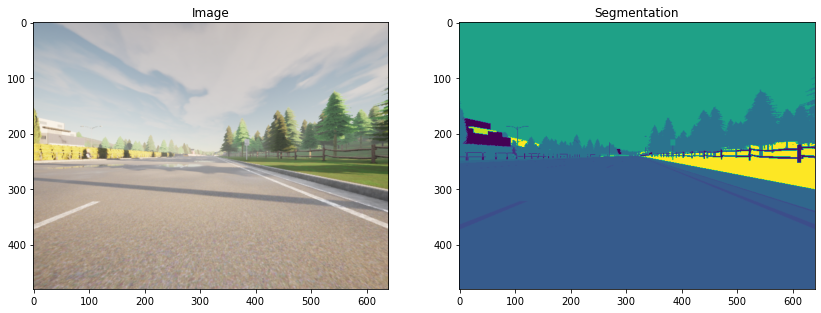

In [26]:
N = 200
# read all images in a dir with path
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

In [4]:
# Create a constant tensor for creating datasets with tensors
image_list = tf.constant(image_list)
image_list = tf.constant(mask_list)

# Creating datasets with tensors
dataset = tf.data.Dataset.from_tensor_slices((image_list, image_list))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'C:\\Users\\ii.karimli\\Desktop\\git proects\\U-net\\data\\CameraMask\\000026.png', shape=(), dtype=string)
tf.Tensor(b'C:\\Users\\ii.karimli\\Desktop\\git proects\\U-net\\data\\CameraMask\\000026.png', shape=(), dtype=string)


#### Preprocessing

In [5]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

### U-Net


Architecture:
<img src="images/unet.png" style="width:700px;height:400;">

We basically can seperate architecture in two parts encoding part which only contains convolution layers and decoding that contains deconvolution layers 

Example for intuition how it will segmentize:

<img src="images/example.png" style="width:700px;height:400;">

In [6]:

from tensorflow.keras import layers

class Unet(layers.Layer):
    
    def __init__(self,input_size=(96, 128, 3)):
        
        self.input_size = input_size
        self.Input = layers.Input(input_size)
        
        self.Conv2D =  layers.Conv2D
        self.Maxpool =  layers.MaxPooling2D
        self.Dropout =  layers.Dropout 
        self.Conv2DTranspose =  layers.Conv2DTranspose
        self.concatenate =  layers.concatenate
        
        self.skipconnections = list()
        
        
    def encoding_step(self,inputs, n_filters, max_pooling = True, dropout_prob = 0):
        
        conv = self.Conv2D(n_filters,
                  (3,3),   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer="he_normal")(inputs)
        
        conv = self.Conv2D(n_filters, 
                  (3,3),   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
        
        if dropout_prob > 0: conv = self.Dropout(dropout_prob)(conv)
            
        if max_pooling:      next_step = self.Maxpool((2,2))(conv)
        else:                next_step = conv
            
        
        self.skipconnections.append(conv)
        
        return next_step
        

    def decoding_step(self,inputs,skip_connection_input,n_filters):
        
        deconv = self.Conv2DTranspose(
                 n_filters,   
                 (3,3),    # Kernel size
                 strides=(2,2),
                 padding='same')(inputs)
        
        
        # Connect the outputs from encoding steps to decoding steps
        combination = self.concatenate([deconv,skip_connection_input])
        
        conv = self.Conv2D(n_filters, 
                  (3,3),   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(combination)
        
        conv = self.Conv2D(n_filters, 
                  (3,3),   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
        
        return conv
    
    def unet(self,n_filters = 32, n_classes = 23):
        Input = self.Input
        
        ## Numbers in the layer variables corresponds the depth of layer for example decoding_step5 means first step 
        # of decoding happens in depth of 5th level
        encoding_step1 = self.encoding_step(Input, n_filters=n_filters)
        encoding_step2 = self.encoding_step(encoding_step1, n_filters = 2*n_filters)
        encoding_step3 = self.encoding_step(encoding_step2, n_filters = 4*n_filters)
        encoding_step4 = self.encoding_step(encoding_step3, n_filters = 8*n_filters, dropout_prob=0.3)
        encoding_step5 = self.encoding_step(encoding_step4, n_filters = 16*n_filters, max_pooling = False 
                                                                                    ,dropout_prob = 0.3)
        
        # We need to reverse the self.skipconnection list to get better indexing
        self.skipconnections.reverse() 
        
        
        decoding_step4 = self.decoding_step(encoding_step5 ,self.skipconnections[1], n_filters = 8*n_filters)
        decoding_step3 = self.decoding_step(decoding_step4 ,self.skipconnections[2], n_filters = 4*n_filters)
        decoding_step2 = self.decoding_step(decoding_step3 ,self.skipconnections[3], n_filters = 2*n_filters)
        decoding_step1 = self.decoding_step(decoding_step2 ,self.skipconnections[4], n_filters = 1*n_filters)
        
        # We have finished the valley in the architecture
        
        #last layers for final decisions
        decision_layer1 = self.Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(decoding_step1)
        
        decision_layer1_1 = self.Conv2D(n_classes,1,padding = 'same')(decision_layer1)
        
        model = tf.keras.Model(inputs=Input, outputs=decision_layer1_1)
        
        return model
        
        
    

In [13]:
unet_model = Unet(input_size=(96, 128, 3)).unet()

In [14]:
unet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 96, 128, 32)  896         ['input_2[0][0]']                
                                                                                                  
 conv2d_21 (Conv2D)             (None, 96, 128, 32)  9248        ['conv2d_20[0][0]']              
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 48, 64, 32)  0           ['conv2d_21[0][0]']        

Total params: 8,640,471
Trainable params: 8,640,471
Non-trainable params: 0
__________________________________________________________________________________________________


In [15]:
unet_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In the cell below, i run it a few times in order to train the model step by step, because after certain epoch mainly, after 35 or 40 optimization just overshoots and gets lover accuracy.  We can solve it b decay rate changing batch size and etc for now i ll not concentrate this training part such that my main objective is to show the capability of u-net architecture in segmentation tasks

In [17]:
EPOCHS = 8
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
processed_image_ds.batch(BATCH_SIZE)


# .cache()    - caches the dataset in memory (avoids having to reapply preprocessing transformations to the input)
# .shuffle(BUFFER_SIZE)  - shuffle the samples to have always a random order of samples fed to the network
# .batch(BATCH_SIZE)     - batch samples in chunks of size BATCH_SIZE (except the last one, that may be smaller)
# .repeat())   - repeat forever, meaning the dataset will keep producing batches and never terminate running out of data.

train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet_model.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/8
34/34 [==============================] - 198s 6s/step - loss: 0.1120 - accuracy: 0.9647
Epoch 2/8
34/34 [==============================] - 209s 6s/step - loss: 0.1088 - accuracy: 0.9649
Epoch 3/8
34/34 [==============================] - 208s 6s/step - loss: 0.0947 - accuracy: 0.9698
Epoch 4/8
34/34 [==============================] - 192s 6s/step - loss: 0.0851 - accuracy: 0.9727
Epoch 5/8
34/34 [==============================] - 221s 7s/step - loss: 0.0740 - accuracy: 0.9765
Epoch 6/8
34/34 [==============================] - 189s 6s/step - loss: 0.0691 - accuracy: 0.9776
Epoch 7/8
34/34 [==============================] - 195s 6s/step - loss: 0.0591 - accuracy: 0.9812
Epoch 8/8
34/34 [==============================] - 191s 6s/step - loss: 0.0528 - accuracy: 0.9835


In [18]:
unet_model.save('unet_first.h5')

### Testing the model with test images

In [7]:
import tensorflow as tf

In [8]:
unet_model = tf.keras.models.load_model('unet_first.h5')

In [9]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [49]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [54]:
def show_predictions(dataset=None, num=1):
    
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet_model.predict(image)
            display([ mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet_model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 1s 1s/step


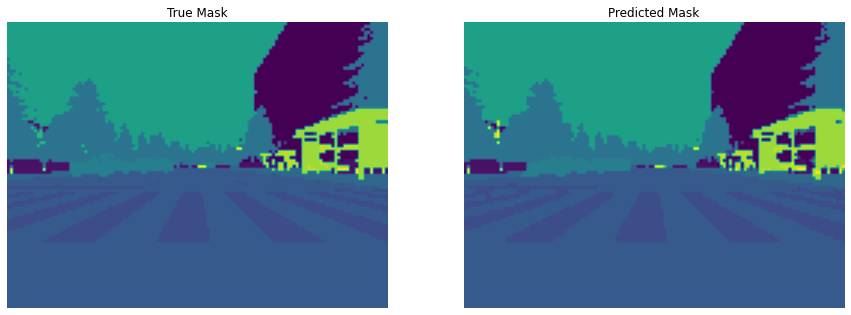

In [59]:
show_predictions(train_dataset)

# Done ! :)